# Laboratorio Número 2

Para este laboratorio haremos uso de las librerías numpy y scipy para manejo matemático de las señales, matplotlib para graficar, pandas para la lectura de los archivos de manera eficiente, y sklearn para tener acceso a implementaciones de modelos de aprendizaje de máquina supervisado.

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)
from scipy.signal import correlate, find_peaks
import glob
plt.rcParams["axes.grid"] = True

Para este laboratorio se tomaron los datos de 22 sujetos a los cuales se les midieron ciertas variables mientras estaban sentados, caminando y corriendo. Entre estas variables se encuentra un EGC, presion arterial, temperatura, aceleración del cuerpo, entre otras.

## Punto #1

Para este punto se plantea observar la evolución de la frecuencia cardiaca versus el tiempo para uno de los individuos. Comencemos cargando los datos de las tres actividades.

In [16]:
subject = "s10"
# Load the data
sit: pd.DataFrame = pd.read_csv("data/" + subject + "_sit.csv")
sit["time"] = pd.to_datetime(sit["time"])

walk: pd.DataFrame = pd.read_csv("data/" + subject + "_walk.csv")
walk["time"] = pd.to_datetime(walk["time"])

run: pd.DataFrame = pd.read_csv("data/" + subject + "_run.csv")
run["time"] = pd.to_datetime(run["time"])
sit.head()

,time,ecg,peaks,pleth_1,pleth_2,pleth_3,pleth_4,pleth_5,pleth_6,lc_1,lc_2,temp_1,temp_2,temp_3,a_x,a_y,a_z,g_x,g_y,g_z
0,2021-01-01 11:42:11.380563,29634,0,66165,68100,3605,90569,99964,6084,6309080,6604837,33.94,36.00,33.172401,5.588950,4.046407,-6.884279,0.000282,-0.071532,0.036767
1,2021-01-01 11:42:11.382563,29687,0,66160,68084,3603,90569,99964,6084,6309080,6604837,33.94,36.00,33.178394,5.601521,4.040421,-6.910018,0.002013,-0.071799,0.033970
2,2021-01-01 11:42:11.384563,29785,0,66149,68081,3606,90571,99960,6082,6308823,6603053,33.94,36.00,33.175400,5.614689,4.033238,-6.938151,0.003079,-0.073396,0.031440
3,2021-01-01 11:42:11.386563,29887,0,66153,68071,3594,90580,99967,6084,6308823,6603053,33.94,36.00,33.181389,5.620076,4.036231,-6.944736,0.004144,-0.075793,0.028644
4,2021-01-01 11:42:11.388563,29944,0,66153,68071,3594,90579,99948,6082,6308823,6603053,33.94,35.63,33.184383,5.618280,4.024858,-6.936954,0.004810,-0.079122,0.025182


En la siguiente gráfica se observan los primeros 3 segundos del minuto quinto de actividad para cada uno de los casos (sentado, caminando, corriendo). Puede observarse que los pulsos tienen menor duración cuando el sujeto está corriendo que cuando está sentado, indicando una mayor frecuencia cardiaca

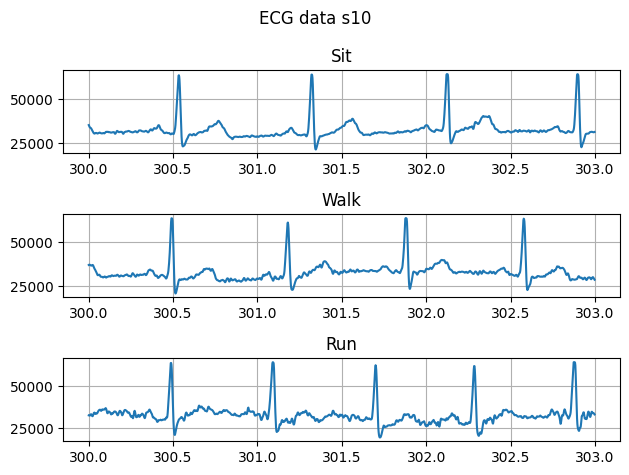

In [24]:
from matplotlib.dates import DateFormatter

frequency = 500  # Hz

figs, axes = plt.subplots(3, 1)

axes[0].plot(
    sit.index[5 * 60 * frequency : (5 * 60 + 3) * frequency] / frequency,
    sit["ecg"][5 * 60 * frequency : (5 * 60 + 3) * frequency],
    label="ecg",
)
axes[0].set_title("Sit")


axes[1].plot(
    walk.index[5 * 60 * frequency : (5 * 60 + 3) * frequency] / frequency,
    walk["ecg"][5 * 60 * frequency : (5 * 60 + 3) * frequency],
    label="ecg",
)
axes[1].set_title("Walk")


axes[2].plot(
    run.index[5 * 60 * frequency : (5 * 60 + 3) * frequency] / frequency,
    run["ecg"][5 * 60 * frequency : (5 * 60 + 3) * frequency],
    label="ecg",
)
axes[2].set_title("Run")

plt.suptitle(f"ECG data {subject}")


plt.tight_layout()

Para encontrar la evolución de la frecuencia respecto al tiempo y teniendo en cuenta de que no es una señal periodica pura sino quasi periódica 
$$ x(n) \approx x(n + kT), k \in Z $$
$$ |x(n) - x(n + kT)| < \epsilon, k \in Z $$

usaremos la autocorrelación para obtener la separación entre los puntos de maxima similitud de la señal consigo misma.
$$ r_{xx}(l) = \sum^{\infty}_{n=-\infty}x(n).x(n-l) $$

Para esto, se toman ventanas de la señal de 10 segundos, con un solapamiento de 5 segundos. Para cada ventana se le resta su valor promedio y se calcula la autocorrelacion. Luego, encontraremos los máximos locales usando la funcion "find_peaks", que nos entrega los indices de estos máximos. Posteriormente encontramos la diferencia entre esos indices y filtramos esta diferencia a valores razonables de frecuencia cardiaca, debido a que hay armónicos correspondientes a frecuencias mayores a 180 y menores a 60 latidos por segundo que pueden tomar mayor magnitud que el principal debido a la forma de la señal. Luego se toma el promedio de estas diferencias.
Teniendo en cuenta de que la señal original fue muestreada a 500 Hz, se establece que la frecuencia en latidos por minuto es de 
$$ F_{cardiaca} = \frac{60 * 500}{l}$$
Donde $l$ es el promedio de las diferencias de los retrasos donde la autocorrelacion supera un umbral de 0.1.

A continuacion se detalla el código y la gráfica de los resultados obtenidos


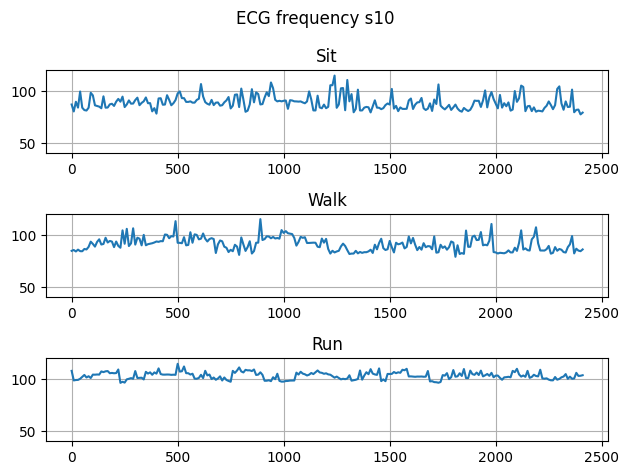

In [32]:
def windowed_auto_correlation_periods(signal, window_size):
    periods = []
    overlap = 0.2
    for i in np.arange(
        0, int(len(signal) - (window_size * overlap)), int(window_size * overlap)
    ):
        window = signal[i  : i + window_size]
        window = window - np.mean(window)
        auto_correlation = np.correlate(window, window, mode="full")
        auto_correlation = auto_correlation / np.max(auto_correlation)
        auto_correlation = auto_correlation[len(auto_correlation) // 2 :]
        auto_correlation = auto_correlation - np.mean(auto_correlation)
        auto_correlation[np.where(auto_correlation < 0.1)] = 0
        peaks  = find_peaks(auto_correlation, prominence=0.1)[0]  
        
        diff = np.diff(peaks)
        diff = diff[np.where(diff > 250)]
        diff = diff[np.where(diff < 400)]


        if len(diff) == 0:
            periods.append(np.mean(periods))
            continue
        periods.append(
            60 * frequency / np.mean(diff)
        )
    return periods


window = 10  # seconds
run_windowed_auto_correlation = windowed_auto_correlation_periods(
    run["ecg"], window * frequency
)
walk_windowed_auto_correlation = windowed_auto_correlation_periods(
    walk["ecg"], window * frequency
)
sit_windowed_auto_correlation = windowed_auto_correlation_periods(
    sit["ecg"], window * frequency
)

fig, axes = plt.subplots(3, 1)

axes[0].plot(
    window * np.arange(0, len(sit_windowed_auto_correlation)),
    sit_windowed_auto_correlation,
)
axes[0].set_title("Sit")
axes[0].set_ylim(40, 120)
axes[1].plot(
    window * np.arange(0, len(walk_windowed_auto_correlation)),
    walk_windowed_auto_correlation,
)
axes[1].set_title("Walk")
axes[1].set_ylim(40, 120)
axes[2].plot(
    window * np.arange(0, len(run_windowed_auto_correlation)),
    run_windowed_auto_correlation,
)
axes[2].set_title("Run")
axes[2].set_ylim(40, 120)

plt.suptitle(f"ECG frequency {subject}")
plt.tight_layout()


Como puede observarse, el valor por el que rondan las gráficas incrementa segun la intensidad de la actividad, cuando el sujeto esta sentado, el valor ronda los 85 latidos por minuto, caminando los 90 y corriendo cerca a los 110 latidos por minuto.
Se debe tener especial cuidado con la ventana que se escoge para la señal, ventanas muy pequeñas que no incluyan suficientes periodos de la señal pueden dar resultados inesperados con esta metodología.

Dependiendo de la calidad de las medidas se deberán ajustar los umbrales para la correlación, se observaron casos en que los periodos de la señal no eran tan claros luego de aplicar la correlación debido a la sensibilidad de la metodología a estos parámetros. Como actividad futura se puede plantear un algoritmo apoyado en machine learning que asegure que los parámetros que se ingresan en esas etapas sean adecuados para cada muestra.


## Punto #2

Para este punto se propone analizar el desfase entre 2 señales diferentes, 

In [33]:
def windowed_cross_correlation_lag(signal_1, signal_2, window_size):
    periods = []
    overlap = 0.2
    for i in np.arange(
        0, int(len(signal) - (window_size * overlap)), int(window_size * overlap)
    ):
        window_1 = signal_1[i : i + window_size]
        window_1 = window_1 - np.mean(window)
        window_2 = signal_2[i : i + window_size]
        window_2 = window_2 - np.mean(window)

        cross_correlation = np.correlate(window, window, mode="full")
        cross_correlation = cross_correlation / np.max(cross_correlation)
        cross_correlation = cross_correlation[len(cross_correlation) // 2 :]
        cross_correlation = cross_correlation - np.mean(cross_correlation)
        cross_correlation[np.where(cross_correlation < 0.1)] = 0
        peaks = find_peaks(cross_correlation, prominence=0.1)[0]

        diff = np.diff(peaks)
        diff = diff[np.where(diff > 250)]
        diff = diff[np.where(diff < 400)]

        if len(diff) == 0:
            periods.append(np.mean(periods))
            continue
        periods.append(60 * frequency / np.mean(diff))
    return periods


cross_correlations = {}
columns = ["ecg", "pleth_3", "pleth_6", "lc_1", "lc_2", "temp_1"]


for column_i in columns:
    for column_j in columns:
        if column_i == column_j:
            continue
        if column_j + "_" + column_i in cross_correlations:
            continue
        cross_correlations[column_i + "_" + column_j] = correlate(
            run[column_i] - run[column_i].mean(),
            run[column_j] - run[column_j].mean(),
            mode="full",
        )
        cross_correlations[column_i + "_" + column_j] = cross_correlations[
            column_i + "_" + column_j
        ] / np.max(cross_correlations[column_i + "_" + column_j])

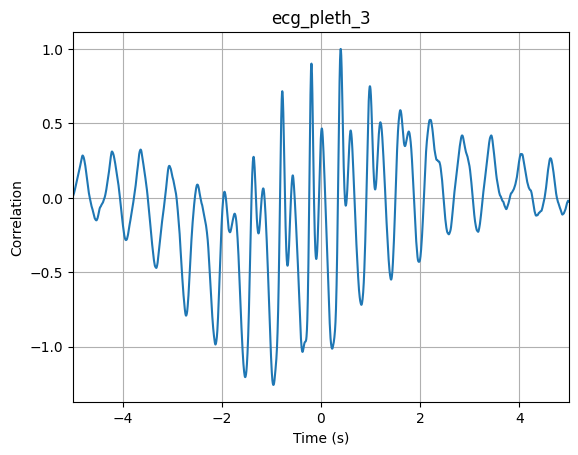

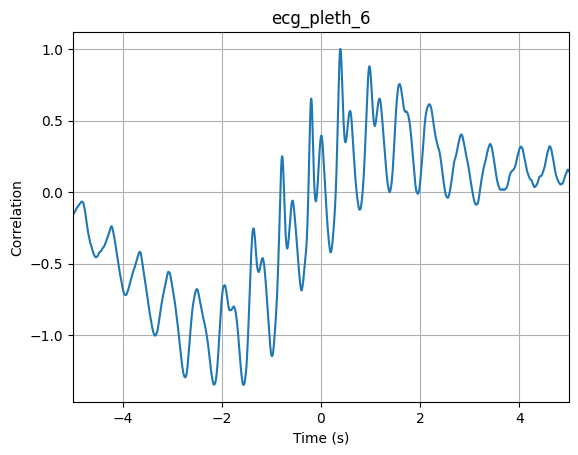

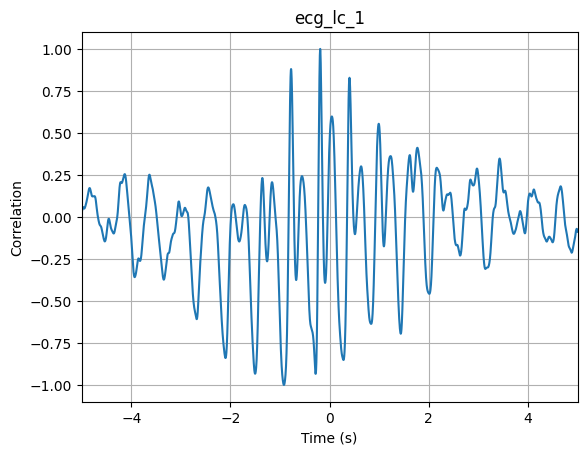

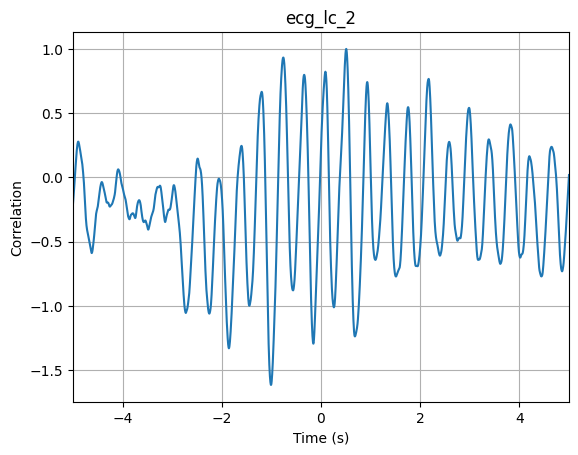

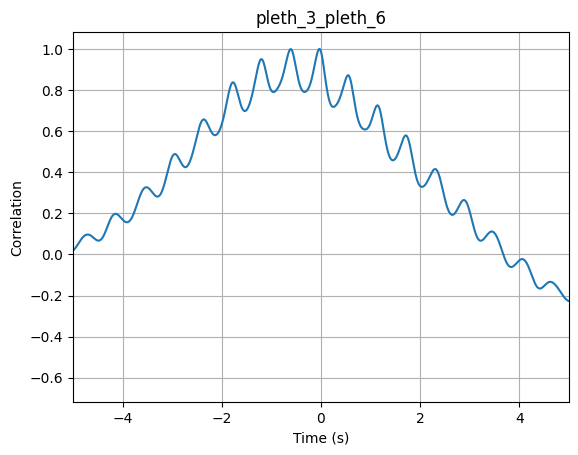

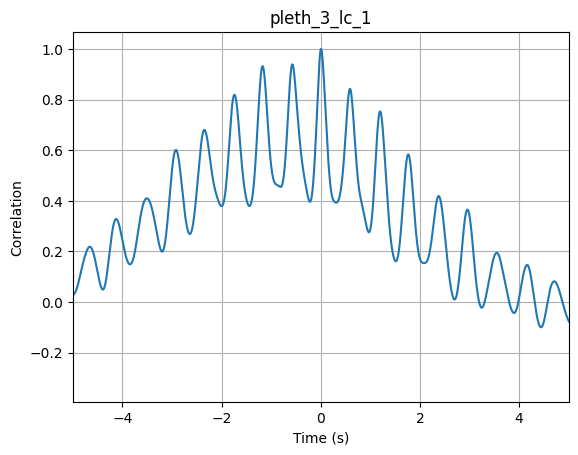

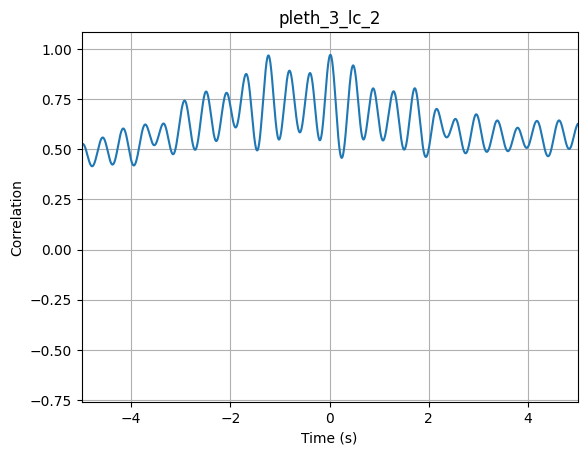

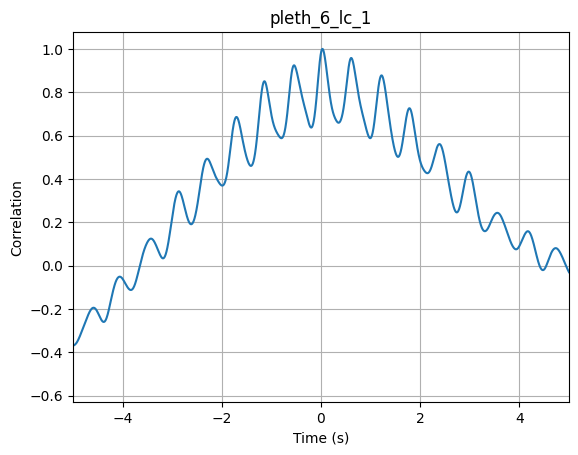

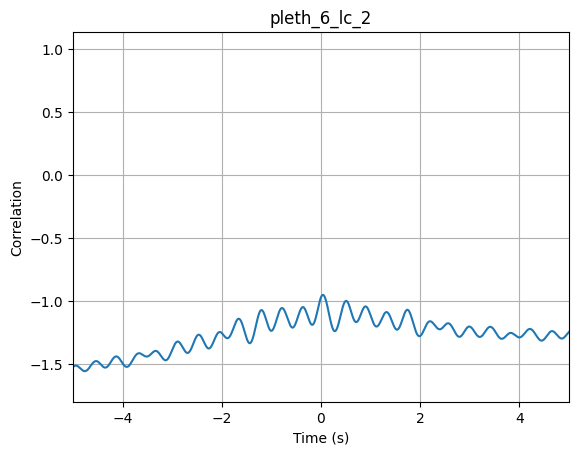

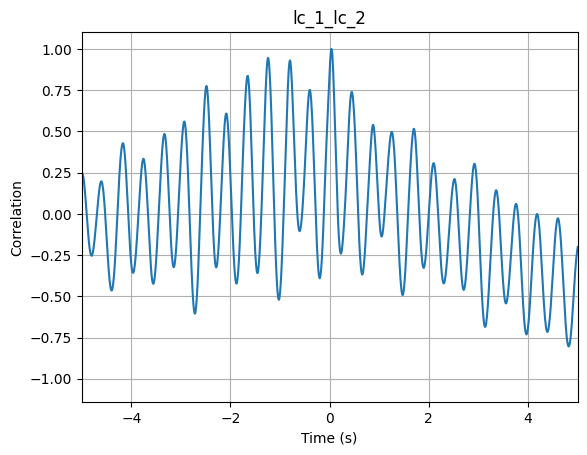

In [35]:
for key, value in cross_correlations.items():
    x = np.arange(-len(value) // 2, len(value) // 2) / frequency
    plt.figure()
    plt.plot(x, value, label=key)
    plt.title(key)
    plt.xlabel("Time (s)")
    plt.ylabel("Correlation")
    plt.xlim(-5, 5)
    plt.show()

In [272]:
def find_frequency_fft(signal, frequency):
    signal = signal - np.mean(signal)
    signal = signal * np.hamming(len(signal))
    signal = fft(signal)
    signal = np.abs(signal)
    signal = signal / np.max(signal)
    frequencies = np.fft.fftfreq(len(signal), 1 / frequency)

    return abs(frequencies[np.argmax(signal)])

subjects_data = pd.read_csv("data/subjects_info.csv")
files = glob.glob("data/s*.csv")
data = []
for file in files:
    try:

        activity = file.split("/")[-1].split("_")[1].split(".")[0]
        data_file: pd.DataFrame = pd.read_csv(file)
        # plt.figure()
        # plt.plot(
        #     correlate(
        #         data_file["ecg"] - data_file["ecg"].mean(), data_file["ecg"]- data_file["ecg"].mean(), mode="full"
        #     )
        # )
        # plt.xlim(len(data_file["ecg"]) - 2000, len(data_file["ecg"]) + 2000)
        # plt.show()
        # find_frequency_fft(data_file["ecg"], 500)
        data.append(
            {
                "subject": file.split("/")[-1].split("_")[0],
                "weight": subjects_data[
                    subjects_data["record"] == file.split("/")[-1].split(".")[0]
                ]["weight"].values[0],
                "height": subjects_data[
                    subjects_data["record"] == file.split("/")[-1].split(".")[0]
                ]["height"].values[0],
                "activity": activity,
                "ecg_frequency": np.median(
                    windowed_auto_correlation_periods(
                        data_file["ecg"], window * frequency
                    )
                ),
                # "temp_1_mean": data_file["temp_1"].mean(),
                # "temp_2_mean": data_file["temp_2"].mean(),
                # "pleth_3_mean": data_file["pleth_3"].mean(),
                # "pleth_6_mean": data_file["pleth_6"].mean(),
                # "lc_1_mean": data_file["lc_1"].mean(),
                # "lc_2_mean": data_file["lc_2"].mean(),
            }
        )
    except Exception as e:
        print(e)
        print(file)


data = pd.DataFrame(data)

/home/andres/digital_signal_processing/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/andres/digital_signal_processing/venv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/andres/digital_signal_processing/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/andres/digital_signal_processing/venv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


KeyboardInterrupt: 

In [ ]:
y = data["activity"]
X = data.drop(columns=["activity", "subject"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


svc = SVC(kernel="linear")
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc.classes_)
disp.plot()

ValueError: Input X contains NaN.
SVC does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

              precision    recall  f1-score   support

         run       0.00      0.00      0.00         0
         sit       0.83      0.62      0.71         8
        walk       0.75      0.60      0.67         5

    accuracy                           0.62        13
   macro avg       0.53      0.41      0.46        13
weighted avg       0.80      0.62      0.70        13



/home/andres/digital_signal_processing/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/andres/digital_signal_processing/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/andres/digital_signal_processing/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

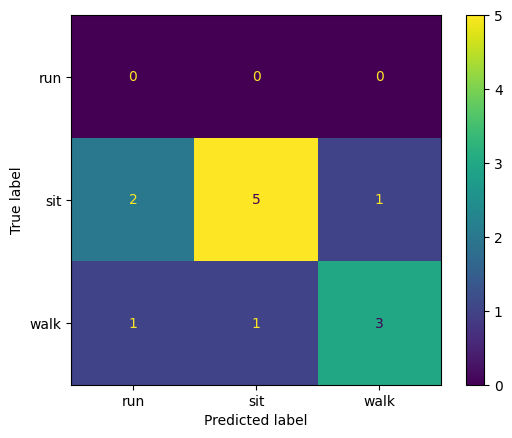

In [ ]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tree.classes_)
disp.plot()